# NLP: Embeddings
    - São únicas em termos de capturar o contexto das palavras e representá-las de forma que palavras com significados semelhantes sejam representadas com tipos semelhantes de Embeddings. Existem duas formas de calcular os embeddings.
    1. Skip Gram
    2. Continuous Bag of Words (CBOW)
    
    - Ambos os métodos fornecem valores de Embeddings que nada mais são do que pesos da camada oculta em uma rede neural.   
    1. O word2vec fornece os valores de incorporação para cada palavra
    2. enquanto doc2vec fornece os valores de incorporação para a frase inteira.

- Vamos usar um conjunto de dados de amostra para ilustrar como podemos criar Embeddings de sequência a partir de uma jornada de varejo online de usuários

In [85]:
pip install gensim 

Note: you may need to restart the kernel to use updated packages.


In [86]:
# Bibliotecas
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [87]:
url='C:/Users/Pc/Desktop/Hartb/machineLearning/PYSPARK/embedding_dataset.csv'

df = spark.read.csv(url,header=True, inferSchema=True)
df.show(5,False)

+----------------------------------------------------------------+------------+-------------------+------------+----------+---------+
|user_id                                                         |page        |timestamp          |visit_number|time_spent|converted|
+----------------------------------------------------------------+------------+-------------------+------------+----------+---------+
|8057ed24427be18922f640b20b60997e7d070946b6c8f48117ae4d6dad0ebb23|homepage    |2017-05-24 19:00:41|0           |0.16666667|1        |
|8057ed24427be18922f640b20b60997e7d070946b6c8f48117ae4d6dad0ebb23|product info|2017-05-24 19:00:51|0           |0.4       |1        |
|8057ed24427be18922f640b20b60997e7d070946b6c8f48117ae4d6dad0ebb23|product info|2017-05-24 19:01:15|0           |0.31666666|1        |
|8057ed24427be18922f640b20b60997e7d070946b6c8f48117ae4d6dad0ebb23|product info|2017-05-24 19:02:42|0           |0.6333333 |1        |
|8057ed24427be18922f640b20b60997e7d070946b6c8f48117ae4d6dad0eb

In [88]:
df.count()

1096955

- O número total de registros no conjunto de dados é próximo a um milhão e há 0,1 milhão de usuários únicos. 
- O tempo gasto por cada usuário em cada uma das páginas da web também é rastreado junto com o status final se o usuário comprou o produto ou não

In [89]:
df.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- page: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- visit_number: integer (nullable = true)
 |-- time_spent: double (nullable = true)
 |-- converted: integer (nullable = true)



In [90]:
df.select('user_id').distinct().count()

104087

In [91]:
df.groupBy('page').count().orderBy('count',ascending=False).show(10,False)

+-------------+------+
|page         |count |
+-------------+------+
|product info |767131|
|homepage     |142456|
|added to cart|67087 |
|others       |39919 |
|offers       |32003 |
|buy          |24916 |
|reviews      |23443 |
+-------------+------+



In [92]:
df.select(['user_id','page','visit_number','time_spent','converted']).show(10,False)

+----------------------------------------------------------------+-------------+------------+-----------+---------+
|user_id                                                         |page         |visit_number|time_spent |converted|
+----------------------------------------------------------------+-------------+------------+-----------+---------+
|8057ed24427be18922f640b20b60997e7d070946b6c8f48117ae4d6dad0ebb23|homepage     |0           |0.16666667 |1        |
|8057ed24427be18922f640b20b60997e7d070946b6c8f48117ae4d6dad0ebb23|product info |0           |0.4        |1        |
|8057ed24427be18922f640b20b60997e7d070946b6c8f48117ae4d6dad0ebb23|product info |0           |0.31666666 |1        |
|8057ed24427be18922f640b20b60997e7d070946b6c8f48117ae4d6dad0ebb23|product info |0           |0.6333333  |1        |
|8057ed24427be18922f640b20b60997e7d070946b6c8f48117ae4d6dad0ebb23|product info |0           |0.15       |1        |
|8057ed24427be18922f640b20b60997e7d070946b6c8f48117ae4d6dad0ebb23|homepa

- A ideia das Embeddings de sequência é traduzir a série de etapas executadas pelo usuário durante sua jornada on-line em uma sequência de páginas, que pode ser usada para calcular pontuações de Embeddings.
- A primeira etapa é remover qualquer uma das páginas duplicadas consecutivas durante a jornada de um usuário
- Criamos uma coluna adicional que captura a página anterior de um usuário

- Window: é uma função no Spark que ajuda a aplicar certa lógica específica a um indivíduo ou grupo de linhas no conjunto de dados
- lag: retorna o valor da linha anterior de uma coluna em relação à linha atual 

In [93]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, lag, udf



In [94]:
w = Window.partitionBy("user_id").orderBy('timestamp')

df = df.withColumn("previous_page", lag("page", 1, 'started').over(w))

df.select('user_id','timestamp','previous_page','page').show(10,False)

+----------------------------------------------------------------+-------------------+-------------+------------+
|user_id                                                         |timestamp          |previous_page|page        |
+----------------------------------------------------------------+-------------------+-------------+------------+
|0005ec769b11a4cf22c7124aecc4ab4bec496df4033e2987bfebfb77c512ea9c|2017-05-02 07:01:04|started      |product info|
|0005ec769b11a4cf22c7124aecc4ab4bec496df4033e2987bfebfb77c512ea9c|2017-05-17 07:03:17|product info |product info|
|0005ec769b11a4cf22c7124aecc4ab4bec496df4033e2987bfebfb77c512ea9c|2017-05-28 11:02:22|product info |product info|
|0005ec769b11a4cf22c7124aecc4ab4bec496df4033e2987bfebfb77c512ea9c|2017-06-03 10:09:25|product info |product info|
|0005ec769b11a4cf22c7124aecc4ab4bec496df4033e2987bfebfb77c512ea9c|2017-06-10 16:42:04|product info |product info|
|0005ec769b11a4cf22c7124aecc4ab4bec496df4033e2987bfebfb77c512ea9c|2017-06-12 18:28:38|pr

In [95]:
def indicator(page, prev_page): 
    if page == prev_page: 
        return 0 
    else: return 1

In [96]:
from pyspark.sql.types import ArrayType,IntegerType
from pyspark.sql.functions import *

In [97]:
page_udf = udf(indicator,IntegerType())

df = df.withColumn("indicator",page_udf(col('page'),col('previous_page'))).withColumn('indicator_cummulative',sum(col('indicator')).over(w))

- O indicador cumulativo é a coluna para rastrear o número de páginas distintas durante a jornada do usuário.

In [98]:
df.select('previous_page','page','indicator','indicator_cummulative').show(20,False)

+-------------+------------+---------+---------------------+
|previous_page|page        |indicator|indicator_cummulative|
+-------------+------------+---------+---------------------+
|started      |product info|1        |1                    |
|product info |product info|0        |1                    |
|product info |product info|0        |1                    |
|product info |product info|0        |1                    |
|product info |product info|0        |1                    |
|product info |product info|0        |1                    |
|product info |product info|0        |1                    |
|product info |product info|0        |1                    |
|product info |product info|0        |1                    |
|product info |product info|0        |1                    |
|product info |product info|0        |1                    |
|product info |product info|0        |1                    |
|product info |product info|0        |1                    |
|product info |product i

- Continuamos criando novos objetos windows para particionar os dados ainda mais, a fim de construir as sequências para cada usuário.

In [99]:
w2 = Window.partitionBy(["user_id",'indicator_cummulative']).orderBy('timestamp')

df = df.withColumn('time_spent_cummulative', sum(col('time_spent')).over(w2))

df.select('timestamp','previous_page','page','indicator','indicator_cummulative','time_spent', 'time_spent_cummulative').show(20,False)

+-------------------+-------------+------------+---------+---------------------+-----------+----------------------+
|timestamp          |previous_page|page        |indicator|indicator_cummulative|time_spent |time_spent_cummulative|
+-------------------+-------------+------------+---------+---------------------+-----------+----------------------+
|2017-05-02 07:01:04|started      |product info|1        |1                    |0.08       |0.08                  |
|2017-05-17 07:03:17|product info |product info|0        |1                    |0.08       |0.16                  |
|2017-05-28 11:02:22|product info |product info|0        |1                    |0.08       |0.24                  |
|2017-06-03 10:09:25|product info |product info|0        |1                    |0.08       |0.32                  |
|2017-06-10 16:42:04|product info |product info|0        |1                    |0.08       |0.4                   |
|2017-06-12 18:28:38|product info |product info|0        |1             

- Na próxima etapa, calculamos o tempo agregado gasto em atividades semelhantes páginas para que apenas um único registro possa ser mantido para representar páginas consecutivas.

In [100]:
w3 = Window.partitionBy(["user_id",'indicator_cummulative']).orderBy(col('timestamp').desc())

df = df.withColumn('final_page',first('page').over(w3)).withColumn('final_time_spent',first('time_spent_cummulative').over(w3))

df.select(['time_spent_cummulative','indicator_cummulative','page','final_page','final_time_spent']).show(10,False)

+----------------------+---------------------+------------+------------+----------------+
|time_spent_cummulative|indicator_cummulative|page        |final_page  |final_time_spent|
+----------------------+---------------------+------------+------------+----------------+
|1.2                   |1                    |product info|product info|1.2             |
|1.1199999999999999    |1                    |product info|product info|1.2             |
|1.0399999999999998    |1                    |product info|product info|1.2             |
|0.9599999999999999    |1                    |product info|product info|1.2             |
|0.8799999999999999    |1                    |product info|product info|1.2             |
|0.7999999999999999    |1                    |product info|product info|1.2             |
|0.72                  |1                    |product info|product info|1.2             |
|0.64                  |1                    |product info|product info|1.2             |
|0.56     

In [101]:
aggregations=[]

aggregations.append(max(col('final_page')).alias('page_emb'))

aggregations.append(max(col('final_time_spent')).alias('time_spent_emb'))

aggregations.append(max(col('converted')).alias('converted_emb'))

df_embedding = df.select(['user_id','indicator_cummulative','final_page','final_time_spent','converted']).groupBy(['user_id','indicator_cummulative']).agg(*aggregations)

w4 = Window.partitionBy(["user_id"]).orderBy('indicator_cummulative')

w5 = Window.partitionBy(["user_id"]).orderBy(col('indicator_cummulative').desc())

- Por fim, usamos uma lista de coleta para combinar todas as páginas da jornada de um usuário em uma única lista e também para o tempo gasto. Como resultado, terminamos com a jornada do usuário na forma de uma lista de páginas e uma lista de tempo gasto.

In [102]:
df_embedding = df_embedding\
.withColumn('journey_page', collect_list(col('page_emb')).over(w4))\
.withColumn('journey_time_temp',collect_list(col('time_spent_emb')).over(w4)) \
.withColumn('journey_page_final',first('journey_page').over(w5))\
.withColumn('journey_time_final', first('journey_time_temp').over(w5)) \
.select(['user_id','journey_page_final','journey_time_final','converted_emb'])

- Continuamos com jornadas únicas de usuários. Cada usuário é representado por um único vetor de jornada e tempo gasto

In [103]:
df_embedding = df_embedding.dropDuplicates()

df_embedding.count()
 
df_embedding.select('user_id').distinct().count()
 
df_embedding.select('user_id','journey_page_final','journey_time_final').show(10)

+--------------------+--------------------+--------------------+
|             user_id|  journey_page_final|  journey_time_final|
+--------------------+--------------------+--------------------+
|0005ec769b11a4cf2...|      [product info]|               [1.2]|
|000b57de22d67187b...|      [product info]|[0.40333333600000...|
|001a13b2d3fae30b9...|[homepage, produc...|[0.26666668, 3.09...|
|0021689e622e8f268...|[homepage, produc...|[0.11666667, 8.26...|
|00323567146f62efb...|[homepage, produc...|[0.28333333, 0.26...|
|0038eeefa396cff29...|[product info, ho...|[0.58, 19.466667,...|
|003d29d24cff1d994...|[homepage, produc...|[0.25, 0.89666667...|
|00495ae8c90665343...|      [product info]|[1.4733333000000004]|
|004e96d0dc01f2541...|      [product info]|[3.5533333000000002]|
|0058982521702bf10...|      [product info]|       [2.210000036]|
+--------------------+--------------------+--------------------+
only showing top 10 rows



- Agora que temos as jornadas do usuário e a lista de tempo gasto, convertemos esse dataframe em um dataframe do Pandas e construímos um modelo word2vec usando essas sequências de jornada. Temos que instalar uma biblioteca gensim primeiro para usar o word2vec. Usamos o tamanho de incorporação de 100 para mantê-lo simples.

In [104]:
from gensim.models import Word2Vec

In [105]:
EMBEDDING_SIZE = 100

In [106]:
pd_df_emb0 = df_embedding.toPandas()

Exception ignored in: <function JavaWrapper.__del__ at 0x000001E3270CD280>
Traceback (most recent call last):
  File "C:\Users\Pc\spark\spark_unzipped\python\pyspark\ml\wrapper.py", line 53, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'PCA' object has no attribute '_java_obj'
Exception ignored in: <function JavaWrapper.__del__ at 0x000001E3270CD280>
Traceback (most recent call last):
  File "C:\Users\Pc\spark\spark_unzipped\python\pyspark\ml\wrapper.py", line 53, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'PCA' object has no attribute '_java_obj'


In [107]:
pd_df_embedding = pd_df_emb0.reset_index(drop=True)
pd_df_embedding

,user_id,journey_page_final,journey_time_final,converted_emb
0,0005ec769b11a4cf22c7124aecc4ab4bec496df4033e29...,[product info],[1.2],0
1,000b57de22d67187b62f4358a063ed49578cee26b49ec9...,[product info],[0.40333333600000004],0
2,001a13b2d3fae30b92d751c06f1edcfa222b1e488f96f7...,"[homepage, product info]","[0.26666668, 3.0999999860000003]",0
3,0021689e622e8f268c0da22075606a1b79aa228fab57f0...,"[homepage, product info]","[0.11666667, 8.266666559999999]",0
4,00323567146f62efb583248589bd17503177ea0fe16447...,"[homepage, product info, others, product info,...","[0.28333333, 0.266666665, 0.13333334, 0.650000...",0
...,...,...,...,...
104082,ffa8ffa4cab3553340955a52a9e84cea5eed111fa3d571...,"[homepage, product info]","[0.08, 8.91666694]",0
104083,ffb19abd0571ea668123df60b6c8838b0018eab717da7d...,"[homepage, product info, homepage, product info]","[0.16666667, 0.333333335, 0.6, 0.08]",0
104084,ffc57f3c1757a775cd0ed734f825368d67409d2cacca9f...,"[homepage, offers, product info, others, offer...","[0.36666667, 0.46666667, 0.51666665, 0.3166666...",0
104085,ffca62be7159e9d89cf8669b798e5b356943ed34f5944e...,"[homepage, buy, added to cart, buy, offers, pr...","[0.5, 0.31666666, 2.1666666, 0.2, 1.6333333, 0...",1


- Como podemos observar, o tamanho do vocabulário é 7 porque estávamos lidando com apenas 7 categorias de páginas. Cada uma dessas categorias de páginas agora pode ser representada com a ajuda de um vetor de incorporação de tamanho 100.

In [108]:
model = Word2Vec(pd_df_embedding['journey_page_final'], vector_size = EMBEDDING_SIZE)
print(model)

Word2Vec<vocab=7, vector_size=100, alpha=0.025>


 - Como podemos observar, o tamanho do vocabulário é 7 porque estávamos lidando com apenas 7 categorias de páginas. Cada uma dessas categorias de páginas agora pode ser representada com a ajuda de um vetor de incorporação de tamanho 100.

In [109]:
# https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4
page_categories = list(model.wv.index_to_key)
print(page_categories)

['product info', 'homepage', 'added to cart', 'others', 'offers', 'buy', 'reviews']


In [110]:
print(model.wv['reviews'])

[ 0.36597863 -0.06971747  0.10842149  0.43293414  0.01364499 -0.22523117
  0.61558765  0.4236921  -0.28995028 -0.3480174   0.81548375  0.02379438
 -0.02090789  0.8959997  -0.20670271 -0.02195967  1.0749462   0.604692
 -0.38458368 -0.799134    0.35656646 -0.09409063  0.96460956 -0.01108285
  0.3194355   0.16426499 -0.12228157 -0.00718816 -0.15489823 -0.23955956
  0.2825386   0.57161325  0.08396921  0.00306738 -0.47939467  0.17849728
 -0.07138804 -0.8566406  -0.4984068  -0.48370355  0.26806355 -0.16005003
  0.45012796 -0.6663513   0.33140042  0.9048112  -0.65521187 -0.5885475
 -0.24895494  0.08147877 -0.08714269 -0.6267343  -1.0616149  -0.01008507
 -0.44398707 -0.71917677  0.06559931 -0.52654994 -0.52880865 -0.26230088
 -0.23123159 -0.19705372  0.44124997 -0.1543346  -0.23413935  0.5766905
 -0.2992646  -0.05700471 -0.54179585 -0.23399906  0.11183896  0.50920707
 -0.2022493   0.37454018  0.5679308  -0.7388534   0.49593416  0.54534805
 -0.37134433  0.18563953  0.13249299 -0.23521152 -0.275

In [111]:
model.wv['offers'].shape

# Para criar a matriz de incorporação, podemos usar um modelo e passar o vocabulário do modelo; resultaria em uma matriz de tamanho (7,100)

(100,)

In [112]:
X = model.wv[model.wv.index_to_key]
X.shape

(7, 100)

# Para entender melhor a relação entre essas páginas categorias, podemos usar uma técnica de redução de dimensionalidade (PCA) e plotar essas sete incorporações de página em um espaço bidimensional.

In [113]:
from pyspark.ml.feature import PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

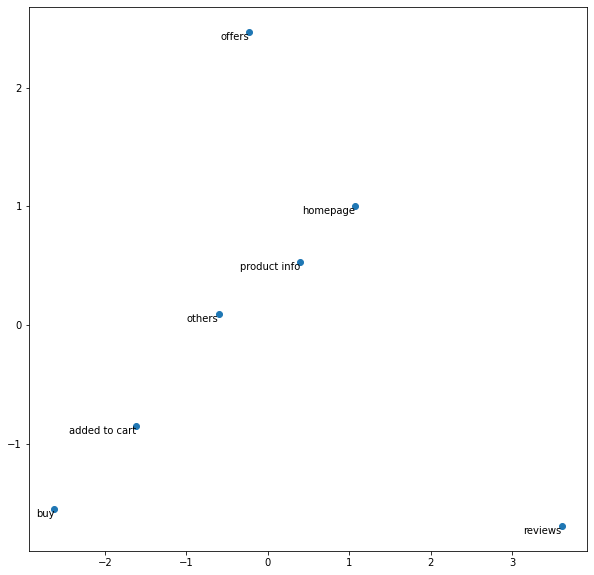

In [114]:
# http://ethen8181.github.io/machine-learning/big_data/spark_pca.html
# https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
pca = PCA(n_components=2)
result = pca.fit_transform(X)
plt.figure(figsize=(10,10))
plt.scatter(result[:, 0], result[:, 1])
for i,page_category in enumerate(page_categories):
 plt.annotate(page_category,horizontalalignment='right', 
verticalalignment='top',xy=(result[i, 0], result[i, 1]))
plt.show()


- Como podemos ver claramente, as incorporações de comprar e adicionar ao carrinho estão próximas umas das outras em termos de similaridade, enquanto a página inicial e as informações do produto também estão próximas umas das outras. Ofertas e avaliações são totalmente separadas quando se trata de representação por meio de incorporações. Essas incorporações individuais podem ser combinadas e usadas para comparação e classificação da jornada do usuário usando Machine Learning.